In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import joblib
import datetime as dt

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.models as models

#from skimage import io
import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report
from sklearn import metrics, preprocessing
from scipy.ndimage import zoom
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import albumentations as A
import albumentations.pytorch
import wandb

#### Hyper Param Setting

In [2]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'resnet152',
    'img_size': 260,
    'epochs': 200,
    'train_bs':64,
    'valid_bs':64,
    'lr': 1e-4, ## learning rate
    'num_workers': 8,
    'verbose_step': 1,
    'patience' : 5,
    'label_encoder':True,
    'device': 'cuda:0',
    'freezing': False,
    'trainable_layer': 12,
    'model_path': './models'
}

#### wandb init

In [3]:
category = '16_classes'
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M")
project_name = 'KD_'+ CFG['model'] + '_' + category
user = 'hojunking'
run_name = project_name + '_' + run_id

In [4]:
# Data split
main_path = '../Data/carbon_data/'
label_list = ["10Kwalk","battery",'box','else','bottle','handkerchief',
              'milk', 'paper', 'pet','plug','receipt', 'shopping bag', 'stairs',
             'transportation', 'trash picking', 'dishes']

total_train_img_paths = []
total_train_img_labels = []
total_test_img_paths = []
total_test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}',end=' ')
    img_paths = [] 
    img_labels = []

    # default ratio
    train_ratio = 1500
    test_ratio = 500

    dir_path = main_path + label ## 레이블 폴더 경로
    count = 0
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
    
        for img in filenames: ## 각 파일 경로, 레이블 저장
            count +=1
            if count > train_ratio + test_ratio + 10000:
                break
            
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    print(len(img_paths))

    if label == 'else': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
        train_ratio = 3000
        test_ratio = 785
    elif label == 'dishes': 
        train_ratio = 4279
        test_ratio = 1070
    elif label == 'handkerchief':
        train_ratio = 2000
        test_ratio = 433     
    elif label == 'milk':
        train_ratio = 2000
        test_ratio = 375
    elif label == 'paper':
        train_ratio = 1300
        test_ratio = 365
    elif label == 'pet':
        train_ratio = 2000
        test_ratio = 404
    elif label == 'plug':
        train_ratio = 2350
        test_ratio = 581
    elif label == 'receipt':
        train_ratio = 600
        test_ratio = 243 
    elif label == 'shopping bag':
        train_ratio = 1300
        test_ratio = 413
    elif label == 'stairs':
        train_ratio = 3250
        test_ratio = 811
    elif label == 'bottle':
        train_ratio = 4921
        test_ratio = 1231
    elif label == 'transportation':
        train_ratio = 1800
        test_ratio = 435
    elif label == 'trash picking':
        train_ratio = 1302
        test_ratio = 326
    elif label == '10Kwalk':
        train_ratio = 1556
        test_ratio = 400
    elif label == 'battery':
        train_ratio = 2305
        test_ratio = 500
    elif label == 'box':
        train_ratio = 1600
        test_ratio = 388
        
    total_train_img_paths.extend(img_paths[:train_ratio])
    total_train_img_labels.extend(img_labels[:train_ratio])

    total_test_img_paths.extend(img_paths[-test_ratio:])
    total_test_img_labels.extend(img_labels[-test_ratio:])

print('Train_Images: ',len(total_train_img_paths))
print("Train_Images_labels:", len(total_train_img_labels))
print('Test_Images: ',len(total_test_img_paths))
print("Test_Images_labels:", len(total_test_img_labels))
print("All data",len(total_train_img_paths) + len(total_test_img_paths))

label: 10Kwalk 1956
label: battery 2805
label: box 1988
label: else 3785
label: bottle 6152
label: handkerchief 2433
label: milk 2375
label: paper 1665
label: pet 2404
label: plug 2931
label: receipt 843
label: shopping bag 1713
label: stairs 4061
label: transportation 2236
label: trash picking 1628
label: dishes 5349
Train_Images:  35563
Train_Images_labels: 35563
Test_Images:  8760
Test_Images_labels: 8760
All data 44323


In [5]:
## Pandas 데이터프레임 만들기
trn_df = pd.DataFrame(total_train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = total_train_img_labels
train = trn_df
train

,image_id,dir,label
0,10Kwalk_468.jpg,../Data/carbon_data/10Kwalk,10Kwalk
1,10Kwalk_1557.jpg,../Data/carbon_data/10Kwalk,10Kwalk
2,10Kwalk_724.jpg,../Data/carbon_data/10Kwalk,10Kwalk
3,10Kwalk_1303.jpg,../Data/carbon_data/10Kwalk,10Kwalk
4,10Kwalk_1897.jpg,../Data/carbon_data/10Kwalk,10Kwalk
...,...,...,...
35558,wrap_1250.jpg,../Data/carbon_data/dishes/wrap,dishes
35559,wrap_765.jpg,../Data/carbon_data/dishes/wrap,dishes
35560,wrap_346.jpg,../Data/carbon_data/dishes/wrap,dishes
35561,wrap_1524.jpg,../Data/carbon_data/dishes/wrap,dishes


##### Label Encoding

In [6]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)
train

,image_id,dir,label
0,10Kwalk_468.jpg,../Data/carbon_data/10Kwalk,0
1,10Kwalk_1557.jpg,../Data/carbon_data/10Kwalk,0
2,10Kwalk_724.jpg,../Data/carbon_data/10Kwalk,0
3,10Kwalk_1303.jpg,../Data/carbon_data/10Kwalk,0
4,10Kwalk_1897.jpg,../Data/carbon_data/10Kwalk,0
...,...,...,...
35558,wrap_1250.jpg,../Data/carbon_data/dishes/wrap,4
35559,wrap_765.jpg,../Data/carbon_data/dishes/wrap,4
35560,wrap_346.jpg,../Data/carbon_data/dishes/wrap,4
35561,wrap_1524.jpg,../Data/carbon_data/dishes/wrap,4


In [7]:
def label_encoding_classes():
    # define certain classes to transform differently
    capture_image_classes = ['10Kwalk', 'battery','receipt']
    return le.transform(capture_image_classes)

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [9]:
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [10]:
transform_train = A.Compose([
    A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.75),ratio=(0.90, 1.10)),
    A.HorizontalFlip(p=0.5),
    A.SafeRotate(p=0.5, limit=(-20, 20), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
    A.ColorJitter(always_apply=True, p=0.5, contrast=0.2, saturation=0.3, hue=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

transform_train_cap = A.Compose([
    A.OneOf([
        A.Compose([
            A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.85),ratio=(0.90, 1.10)),
        ], p=0.6),
        A.Compose([
            A.Resize(p=1, height = CFG['img_size'], width = CFG['img_size']),
        ], p=0.4),
    ], p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
    A.pytorch.transforms.ToTensorV2()
])

transform_test = A.Compose([
    A.Resize(height = CFG['img_size'], width = CFG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

In [11]:
class CustomDataset(Dataset):
    def __init__(self, df, data_root, transform=None, transform2=None, output_label=True, encoded_class=None):
        super(CustomDataset,self).__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.transform2 = transform2
        self.data_root = data_root
        self.output_label = output_label
         
        if encoded_class == True:
            print('test')
            self.encoded_class = label_encoding_classes()
        else:
            self.encoded_class = encoded_class
            
        if output_label == True:
            self.labels = self.df['label'].values
        
    # AUGMENTATION DIFFERENTLY DEPENDING ON THE TARGET
    def custom_augmentation(self, img, target):
        if self.encoded_class is not None and target in self.encoded_class:
            return self.transform2(image=img)
        else:
            return self.transform(image=img)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # GET IMAGES
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)
        
        # GET LABELS
        if self.output_label:
            target = self.labels[index]
            
            # CUSTOM AUGMENTATION
            transformed = self.custom_augmentation(img, target) 
            img = transformed['image']
            return img, target
        else:
            transformed =self.transform(image=img)
            img = transformed['image']
            return img

In [12]:
# LOAD PRE-TRAINED MODEL
class Teacher(nn.Module):
    def __init__(self, model_arch_str, num_classes= 2,pretrained=True):
        super(Teacher, self).__init__()
        model_arch = getattr(models, model_arch_str)
        self.backbone = model_arch(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [13]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
    
        
    train_ds = CustomDataset(train_, train_data_root, transform=transform_train,
                            transform2=transform_train_cap, output_label=True, encoded_class=CFG['label_encoder'])
    valid_ds = CustomDataset(valid_, valid_data_root, transform=transform_test,
                            output_label=True)
    # WEIGHTEDRANDOMSAMPLER
    class_counts = train_.label.value_counts(sort=False).to_dict()
    num_samples = sum(class_counts.values())
    print(f'cls_cnts: {len(class_counts)}\nnum_samples:{num_samples}')
    
    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}
    t_labels = train_.label.to_list()
    
    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))]


    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}

    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))] 
    sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=False,
        sampler=sampler, 
        num_workers=CFG['num_workers']
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [14]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None):
    t = time.time()
    
    # SET MODEL TRAINING MODE
    model.train()
    
    running_loss = None
    loss_sum = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        optimizer.zero_grad()
        
        # TEACHER MODEL PREDICTION
        with torch.cuda.amp.autocast():
            image_preds = model(imgs)   #output = model(input)

            loss = loss_fn(image_preds, image_labels)
            loss_sum+=loss.detach()
            
            # BACKPROPAGATION
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01    
        
            # TQDM VERBOSE_STEP TRACKING
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
        
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
    if scheduler is not None:
        scheduler.step()
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    
    accuracy = (image_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    return image_preds_all, accuracy, trn_loss, matrix, epoch_f1

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    t = time.time()
    
    # SET MODEL VALID MODE
    model.eval()
    
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        # TEACHER MODEL PREDICTION
        image_preds = model(imgs)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        # TQDM
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    acc = (image_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    return image_preds_all, acc, val_loss, matrix, epoch_f1

In [15]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        print(f' present score: {score}')
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [ ]:
if __name__ == '__main__':
    seed_everything(CFG['seed'])
    
    # WANDB TRACKER INIT
    wandb.init(project=project_name, entity=user)
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    model_dir = CFG['model_path'] + '/{}'.format(run_name)
    train_dir = train.dir.values
    best_fold = 0
    best_f1 =0.0
    print('Model: {}'.format(CFG['model']))
    # MAKE MODEL DIR
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    # STRATIFIED K-FOLD DEFINITION
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    # TEST PROCESS FOLD BREAK
    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'Training start with fold: {fold} epoch: {CFG["epochs"]} \n')

        # EARLY STOPPING DEFINITION
        early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)

        # DATALOADER DEFINITION
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)

        # MODEL & DEVICE DEFINITION 
        device = torch.device(CFG['device'])
        model =Teacher(CFG['model'], train.label.nunique(), pretrained=True)
        
        # MODEL FREEZING
        #model.freezing(freeze = CFG['freezing'], trainable_layer = CFG['trainable_layer'])
        if CFG['freezing'] ==True:
            for name, param in model.named_parameters():
                if param.requires_grad == True:
                    print(f"{name}: {param.requires_grad}")

        model.to(device)
        # MODEL DATA PARALLEL
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        scaler = torch.cuda.amp.GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5)

        # CRITERION (LOSS FUNCTION)
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)

        wandb.watch(model, loss_tr, log='all')
        train_acc_list = []
        train_matrix_list = []
        train_f1_list = []
        valid_acc_list = []
        valid_matrix_list = []
        valid_f1_list = []
        

        start = time.time()
        print(f'Fold: {fold}')
        for epoch in range(CFG['epochs']):
            print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))

            # TRAINIG
            train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, model, loss_tr,
                                                                        optimizer, train_loader, device, scheduler=scheduler)
            wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

            # VALIDATION
            with torch.no_grad():
                valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, model, loss_fn,
                                                                        val_loader, device, scheduler=None)
                wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
            print(f'Epoch [{epoch}], Train Loss : [{train_loss :.5f}] Val Loss : [{valid_loss :.5f}] Val F1 Score : [{valid_f1:.5f}]')
            
            # SAVE ALL RESULTS
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            train_f1_list.append(train_f1)

            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            valid_f1_list.append(valid_f1)

            # MODEL SAVE (THE BEST MODEL OF ALL OF FOLD PROCESS)
            if valid_f1 > best_f1:
                best_f1 = valid_f1
                best_epoch = epoch
                # SAVE WITH DATAPARARELLEL WRAPPER
                #torch.save(model.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))
                # SAVE WITHOUT DATAPARARELLEL WRAPPER
                torch.save(model.module.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))

            # EARLY STOPPING
            stop = early_stopping(valid_f1)
            if stop:
                print("stop called")   
                break

        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        # PRINT BEST F1 SCORE MODEL OF FOLD
        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'fold: {fold}, Best Epoch : {best_index}/ {len(valid_f1_list)}')
        print(f'Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        print('-----------------------------------------------------------------------')

        # K-FOLD END
        if valid_f1_list[best_index] > best_fold:
            best_fold = valid_f1_list[best_index]
            top_fold = fold
    print(f'Best Fold F1 score: {best_fold} Top fold : {top_fold}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Model: resnet152
Training start with fold: 0 epoch: 200 

test
cls_cnts: 16
num_samples:28450


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold: 0
Epoch 0/199


epoch 0 loss: 0.2786: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [03:04<00:00,  1.65s/it]


Epoch [0], Train Loss : [0.42495] Val Loss : [0.27900] Val F1 Score : [0.91472]
 present score: 0.9147158305234195
Epoch 1/199


epoch 1 loss: 0.2863: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:59<00:00,  1.61s/it]


Epoch [1], Train Loss : [0.22845] Val Loss : [0.28667] Val F1 Score : [0.91924]
 present score: 0.919243923995805
Epoch 2/199


epoch 2 loss: 0.2705: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:59<00:00,  1.60s/it]


Epoch [2], Train Loss : [0.17893] Val Loss : [0.27457] Val F1 Score : [0.92645]
 present score: 0.9264455057691097
Epoch 3/199


epoch 3 loss: 0.2473: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:59<00:00,  1.60s/it]


Epoch [3], Train Loss : [0.15516] Val Loss : [0.25239] Val F1 Score : [0.93191]
 present score: 0.9319096655885097
Epoch 4/199


epoch 4 loss: 0.2468: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:56<00:00,  1.58s/it]


Epoch [4], Train Loss : [0.12414] Val Loss : [0.24584] Val F1 Score : [0.93285]
 present score: 0.9328530034237578
Epoch 5/199


epoch 5 loss: 0.1859: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:58<00:00,  1.59s/it]


Epoch [5], Train Loss : [0.07931] Val Loss : [0.18488] Val F1 Score : [0.95010]
 present score: 0.9500985806720292
Epoch 6/199


epoch 6 loss: 0.2034: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [03:01<00:00,  1.62s/it]


Epoch [6], Train Loss : [0.05503] Val Loss : [0.20349] Val F1 Score : [0.95038]
 present score: 0.9503801635783031
Epoch 7/199


epoch 7 loss: 0.2127: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [03:01<00:00,  1.62s/it]

Epoch [7], Train Loss : [0.05190] Val Loss : [0.21189] Val F1 Score : [0.94797]
 present score: 0.9479717035277554
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9503801635783031
Epoch 8/199



epoch 8 loss: 0.2212: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [03:00<00:00,  1.61s/it]

Epoch [8], Train Loss : [0.04807] Val Loss : [0.22155] Val F1 Score : [0.94348]
 present score: 0.9434790478748765
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9503801635783031
Epoch 9/199



epoch 9 loss: 0.2236: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [03:00<00:00,  1.61s/it]

Epoch [9], Train Loss : [0.04972] Val Loss : [0.22289] Val F1 Score : [0.94356]
 present score: 0.9435571298915917
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9503801635783031
Epoch 10/199



epoch 10 loss: 0.1787: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [03:00<00:00,  1.61s/it]


Epoch [10], Train Loss : [0.03078] Val Loss : [0.17760] Val F1 Score : [0.95676]
 present score: 0.956757600634005
Epoch 11/199


epoch 11 loss: 0.1871: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [03:01<00:00,  1.62s/it]

Epoch [11], Train Loss : [0.02089] Val Loss : [0.18570] Val F1 Score : [0.95615]
 present score: 0.9561468550252432
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.956757600634005
Epoch 12/199



epoch 12 loss: 0.1876: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:59<00:00,  1.60s/it]

Epoch [12], Train Loss : [0.02155] Val Loss : [0.18622] Val F1 Score : [0.95535]
 present score: 0.9553480137559918
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.956757600634005
Epoch 13/199



epoch 13 loss: 0.1813: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [03:00<00:00,  1.61s/it]


Epoch [13], Train Loss : [0.01618] Val Loss : [0.18002] Val F1 Score : [0.95729]
 present score: 0.9572894428233051
Epoch 14/199


epoch 14 loss: 0.1828: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:58<00:00,  1.60s/it]


Epoch [14], Train Loss : [0.01691] Val Loss : [0.18140] Val F1 Score : [0.96033]
 present score: 0.9603298055514049
Epoch 15/199


epoch 15 loss: 0.1763: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:59<00:00,  1.60s/it]


Epoch [15], Train Loss : [0.01311] Val Loss : [0.17498] Val F1 Score : [0.96103]
 present score: 0.9610316273337601
Epoch 16/199


epoch 16 loss: 0.1841: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:59<00:00,  1.60s/it]

Epoch [16], Train Loss : [0.01107] Val Loss : [0.18277] Val F1 Score : [0.95874]
 present score: 0.9587426775991086
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9610316273337601
Epoch 17/199



epoch 17 loss: 0.1813: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [03:02<00:00,  1.63s/it]


Epoch [17], Train Loss : [0.01024] Val Loss : [0.17997] Val F1 Score : [0.96124]
 present score: 0.9612377626266402
Epoch 18/199


epoch 18 loss: 0.1886: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:59<00:00,  1.61s/it]

Epoch [18], Train Loss : [0.00721] Val Loss : [0.18725] Val F1 Score : [0.95907]
 present score: 0.9590701403166141
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9612377626266402
Epoch 19/199



epoch 19 loss: 0.1794: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:59<00:00,  1.60s/it]


Epoch [19], Train Loss : [0.00691] Val Loss : [0.17808] Val F1 Score : [0.96288]
 present score: 0.962876165602181
Epoch 20/199


epoch 20 loss: 0.1835: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:57<00:00,  1.59s/it]

Epoch [20], Train Loss : [0.00655] Val Loss : [0.18212] Val F1 Score : [0.96112]
 present score: 0.9611220040186084
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.962876165602181
Epoch 21/199



epoch 21 loss: 0.1861: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:59<00:00,  1.60s/it]

Epoch [21], Train Loss : [0.00548] Val Loss : [0.18469] Val F1 Score : [0.96176]
 present score: 0.9617628386966286
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.962876165602181
Epoch 22/199



epoch 22 loss: 0.1870: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [03:00<00:00,  1.61s/it]

Epoch [22], Train Loss : [0.00571] Val Loss : [0.18560] Val F1 Score : [0.96265]
 present score: 0.9626481768514192
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.962876165602181
Epoch 23/199



epoch 23 loss: 0.1859: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [03:00<00:00,  1.62s/it]

Epoch [23], Train Loss : [0.00595] Val Loss : [0.18445] Val F1 Score : [0.96123]
 present score: 0.9612309188607302
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.962876165602181
Epoch 24/199



epoch 24 loss: 0.1858: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:59<00:00,  1.60s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [24], Train Loss : [0.00500] Val Loss : [0.18440] Val F1 Score : [0.96282]
 present score: 0.9628205161660504
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.962876165602181
stop called
time : 5:16:34
fold: 0, Best Epoch : 19/ 25
Best Train Marco F1 : 0.99843
[[1836    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1 1833    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0 1803    1    1    0    0    0    0    1    0    0    0    0
     0    0]
 [   0    0    0 1729    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    1    0 1824    4    0    0    0    1    0    0    0    0
     0    0]
 [   0    0    0    1   14 1774    0    1    0    1    1    0    0    0
     0    1]
 [   0    0    0    1    0    1 1733    0    0    0    0    0    1    0
     0    0]
 [   0    0    0    0    0    0    0 1776    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    1    0    0    0 

epoch 0 loss: 0.3599: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:51<00:00,  1.53s/it]

Epoch [0], Train Loss : [0.42101] Val Loss : [0.36528] Val F1 Score : [0.89006]
 present score: 0.8900556335281347
Epoch 1/199



epoch 1 loss: 0.2874: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:51<00:00,  1.53s/it]

Epoch [1], Train Loss : [0.22521] Val Loss : [0.29015] Val F1 Score : [0.91693]
 present score: 0.9169331265735365
Epoch 2/199



epoch 2 loss: 0.2597: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:48<00:00,  1.50s/it]

Epoch [2], Train Loss : [0.17619] Val Loss : [0.26304] Val F1 Score : [0.92742]
 present score: 0.9274190996610682
Epoch 3/199



epoch 3 loss: 0.2384: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.52s/it]

Epoch [3], Train Loss : [0.14356] Val Loss : [0.23962] Val F1 Score : [0.93237]
 present score: 0.9323724081223974
Epoch 4/199



epoch 4 loss: 0.2567: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:48<00:00,  1.51s/it]

Epoch [4], Train Loss : [0.14344] Val Loss : [0.25695] Val F1 Score : [0.93407]
 present score: 0.9340734433772162
Epoch 5/199



epoch 5 loss: 0.2109: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.52s/it]

Epoch [5], Train Loss : [0.08162] Val Loss : [0.21034] Val F1 Score : [0.94696]
 present score: 0.9469585550930144
Epoch 6/199



epoch 6 loss: 0.2078: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:49<00:00,  1.52s/it]

Epoch [6], Train Loss : [0.05953] Val Loss : [0.20776] Val F1 Score : [0.94941]
 present score: 0.949412675399813
Epoch 7/199



epoch 7 loss: 0.2088: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:52<00:00,  1.54s/it]

Epoch [7], Train Loss : [0.05204] Val Loss : [0.20898] Val F1 Score : [0.94742]
 present score: 0.947424940297493
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.949412675399813
Epoch 8/199



epoch 8 loss: 0.2246: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:52<00:00,  1.54s/it]

Epoch [8], Train Loss : [0.04522] Val Loss : [0.22379] Val F1 Score : [0.94443]
 present score: 0.9444252757656557
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.949412675399813
Epoch 9/199



epoch 9 loss: 0.2386: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.52s/it]

Epoch [9], Train Loss : [0.04463] Val Loss : [0.23752] Val F1 Score : [0.94341]
 present score: 0.9434137839506365
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.949412675399813
Epoch 10/199



epoch 10 loss: 0.1994: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:49<00:00,  1.51s/it]

Epoch [10], Train Loss : [0.02741] Val Loss : [0.19919] Val F1 Score : [0.95535]
 present score: 0.9553505650540111
Epoch 11/199



epoch 11 loss: 0.2109: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.52s/it]

Epoch [11], Train Loss : [0.02394] Val Loss : [0.21211] Val F1 Score : [0.95326]
 present score: 0.9532556132725827
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9553505650540111
Epoch 12/199



epoch 12 loss: 0.2116: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:51<00:00,  1.53s/it]

Epoch [12], Train Loss : [0.01948] Val Loss : [0.21009] Val F1 Score : [0.95324]
 present score: 0.9532446726901463
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9553505650540111
Epoch 13/199



epoch 13 loss: 0.2134: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.53s/it]

Epoch [13], Train Loss : [0.01741] Val Loss : [0.21211] Val F1 Score : [0.95223]
 present score: 0.9522313493227619
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9553505650540111
Epoch 14/199



epoch 14 loss: 0.2282: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:49<00:00,  1.51s/it]

Epoch [14], Train Loss : [0.01666] Val Loss : [0.22653] Val F1 Score : [0.94987]
 present score: 0.9498683036597765
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9553505650540111
Epoch 15/199



epoch 15 loss: 0.2106: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:51<00:00,  1.54s/it]

Epoch [15], Train Loss : [0.01132] Val Loss : [0.20917] Val F1 Score : [0.95795]
 present score: 0.9579503830713568
Epoch 16/199



epoch 16 loss: 0.2061: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:47<00:00,  1.50s/it]

Epoch [16], Train Loss : [0.01010] Val Loss : [0.20537] Val F1 Score : [0.95843]
 present score: 0.9584336212477805
Epoch 17/199



epoch 17 loss: 0.2131: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:49<00:00,  1.51s/it]

Epoch [17], Train Loss : [0.00827] Val Loss : [0.21335] Val F1 Score : [0.95854]
 present score: 0.9585399846214704
Epoch 18/199



epoch 18 loss: 0.2119: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:49<00:00,  1.51s/it]

Epoch [18], Train Loss : [0.00929] Val Loss : [0.21068] Val F1 Score : [0.95840]
 present score: 0.9583958039262052
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9585399846214704
Epoch 19/199



epoch 19 loss: 0.2102: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:51<00:00,  1.53s/it]

Epoch [19], Train Loss : [0.00802] Val Loss : [0.20888] Val F1 Score : [0.95924]
 present score: 0.9592438402404031
Epoch 20/199



epoch 20 loss: 0.2094: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.52s/it]

Epoch [20], Train Loss : [0.00529] Val Loss : [0.20850] Val F1 Score : [0.95923]
 present score: 0.9592254210533764
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9592438402404031
Epoch 21/199



epoch 21 loss: 0.2143: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:54<00:00,  1.55s/it]

Epoch [21], Train Loss : [0.00506] Val Loss : [0.21327] Val F1 Score : [0.95832]
 present score: 0.9583178215788852
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9592438402404031
Epoch 22/199



epoch 22 loss: 0.2112: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:47<00:00,  1.50s/it]

Epoch [22], Train Loss : [0.00530] Val Loss : [0.21005] Val F1 Score : [0.96021]
 present score: 0.9602059984978721
Epoch 23/199



epoch 23 loss: 0.2201: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:47<00:00,  1.50s/it]

Epoch [23], Train Loss : [0.00438] Val Loss : [0.21841] Val F1 Score : [0.95783]
 present score: 0.957834112887239
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9602059984978721
Epoch 24/199



epoch 24 loss: 0.2185: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:52<00:00,  1.54s/it]

Epoch [24], Train Loss : [0.00456] Val Loss : [0.21760] Val F1 Score : [0.95710]
 present score: 0.9570974306654656
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9602059984978721
Epoch 25/199



epoch 25 loss: 0.2184: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:49<00:00,  1.51s/it]

Epoch [25], Train Loss : [0.00386] Val Loss : [0.21686] Val F1 Score : [0.95932]
 present score: 0.9593158512454186
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9602059984978721
Epoch 26/199



epoch 26 loss: 0.2112: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:51<00:00,  1.53s/it]

Epoch [26], Train Loss : [0.00453] Val Loss : [0.20972] Val F1 Score : [0.95955]
 present score: 0.9595501762354754
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9602059984978721
Epoch 27/199



epoch 27 loss: 0.2122: 100%|█████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.52s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [27], Train Loss : [0.00355] Val Loss : [0.21057] Val F1 Score : [0.95995]
 present score: 0.9599486544909184
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9602059984978721
stop called
time : 5:42:27
fold: 1, Best Epoch : 22/ 28
Best Train Marco F1 : 0.99867
[[1759    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0 1772    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0 1718    0    1    0    0    1    0    0    0    0    0    0
     0    0]
 [   0    0    0 1773    0    0    0    1    0    1    0    0    0    1
     0    0]
 [   0    0    3    0 1783    4    0    0    0    0    1    0    0    0
     0    0]
 [   0    0    1    0    3 1825    0    1    0    0    0    1    1    0
     0    0]
 [   0    0    0    0    0    0 1738    1    0    0    0    0    0    0
     1    1]
 [   0    0    1    0    0    0    0 1795    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    1

epoch 0 loss: 0.3673: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:54<00:00,  1.56s/it]

Epoch [0], Train Loss : [0.42590] Val Loss : [0.36938] Val F1 Score : [0.88950]
 present score: 0.8895035885050553
Epoch 1/199



epoch 1 loss: 0.2697: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:52<00:00,  1.54s/it]

Epoch [1], Train Loss : [0.23243] Val Loss : [0.27438] Val F1 Score : [0.92026]
 present score: 0.9202550656314074
Epoch 2/199



epoch 2 loss: 0.2427: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.52s/it]

Epoch [2], Train Loss : [0.18268] Val Loss : [0.24448] Val F1 Score : [0.92816]
 present score: 0.9281552129751227
Epoch 3/199



epoch 3 loss: 0.2703: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.52s/it]

Epoch [3], Train Loss : [0.15837] Val Loss : [0.27207] Val F1 Score : [0.92239]
 present score: 0.9223870544711799
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9281552129751227
Epoch 4/199



epoch 4 loss: 0.2922: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:50<00:00,  1.52s/it]

Epoch [4], Train Loss : [0.13644] Val Loss : [0.29564] Val F1 Score : [0.92637]
 present score: 0.9263739152023562
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9281552129751227
Epoch 5/199



epoch 5 loss: 0.1829: 100%|██████████████████████████████████████████████████████████████████████| 112/112 [02:51<00:00,  1.53s/it]

Epoch [5], Train Loss : [0.07812] Val Loss : [0.18548] Val F1 Score : [0.95289]
 present score: 0.9528853778746581
Epoch 6/199



epoch 6 loss: 0.0546:  74%|████████████████████████████████████████████████████                  | 331/445 [07:08<03:46,  1.99s/it]

In [16]:
## Pandas Test 데이터프레임 만들기
tst_df = pd.DataFrame(total_test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = total_test_img_labels
test = tst_df
test

,image_id,dir,label
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,10Kwalk
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,10Kwalk
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,10Kwalk
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,10Kwalk
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,10Kwalk
...,...,...,...
8755,wrap_441.jpg,../Data/carbon_data/dishes/wrap,dishes
8756,wrap_307.jpg,../Data/carbon_data/dishes/wrap,dishes
8757,wrap_1273.jpg,../Data/carbon_data/dishes/wrap,dishes
8758,wrap_1137.jpg,../Data/carbon_data/dishes/wrap,dishes


In [17]:
test['label'] = le.fit_transform(test['label'].values)
test

,image_id,dir,label
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,0
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,0
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,0
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,0
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,0
...,...,...,...
8755,wrap_441.jpg,../Data/carbon_data/dishes/wrap,4
8756,wrap_307.jpg,../Data/carbon_data/dishes/wrap,4
8757,wrap_1273.jpg,../Data/carbon_data/dishes/wrap,4
8758,wrap_1137.jpg,../Data/carbon_data/dishes/wrap,4


In [18]:
########################## inference #############################
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [19]:
# RUN INFERENCE
model = Teacher(CFG['model'], test.label.nunique(), pretrained=True)
load_model = CFG['model_path'] + '/KD_resnet152_16_classes_202305151137/' + CFG['model'] + '.pth'

test_dir = test.dir.values

tst_ds = CustomDataset(test, test_dir, transform=transform_test, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)
device = torch.device(CFG['device'])

# INFERENCE VIA MULTI-GPU
# if torch.cuda.device_count() > 1:
#         model = nn.DataParallel(model)
model.to(device)

# RUN INFERENCE
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


#tst_preds = inference_one_epoch(model, tst_loader, device)
predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)
#test['confidence score'] =np.max(predictions, axis=1)
test

/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [02:46<00:00,  1.22s/it]


,image_id,dir,label,pred
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,0,0
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,0,0
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,0,0
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,0,0
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,0,0
...,...,...,...,...
8755,wrap_441.jpg,../Data/carbon_data/dishes/wrap,4,4
8756,wrap_307.jpg,../Data/carbon_data/dishes/wrap,4,4
8757,wrap_1273.jpg,../Data/carbon_data/dishes/wrap,4,4
8758,wrap_1137.jpg,../Data/carbon_data/dishes/wrap,4,4


In [20]:
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
...,...,...,...,...
8755,wrap_441.jpg,../Data/carbon_data/dishes/wrap,dishes,dishes
8756,wrap_307.jpg,../Data/carbon_data/dishes/wrap,dishes,dishes
8757,wrap_1273.jpg,../Data/carbon_data/dishes/wrap,dishes,dishes
8758,wrap_1137.jpg,../Data/carbon_data/dishes/wrap,dishes,dishes


accuracy: 0.9377
f1_score: 0.9396


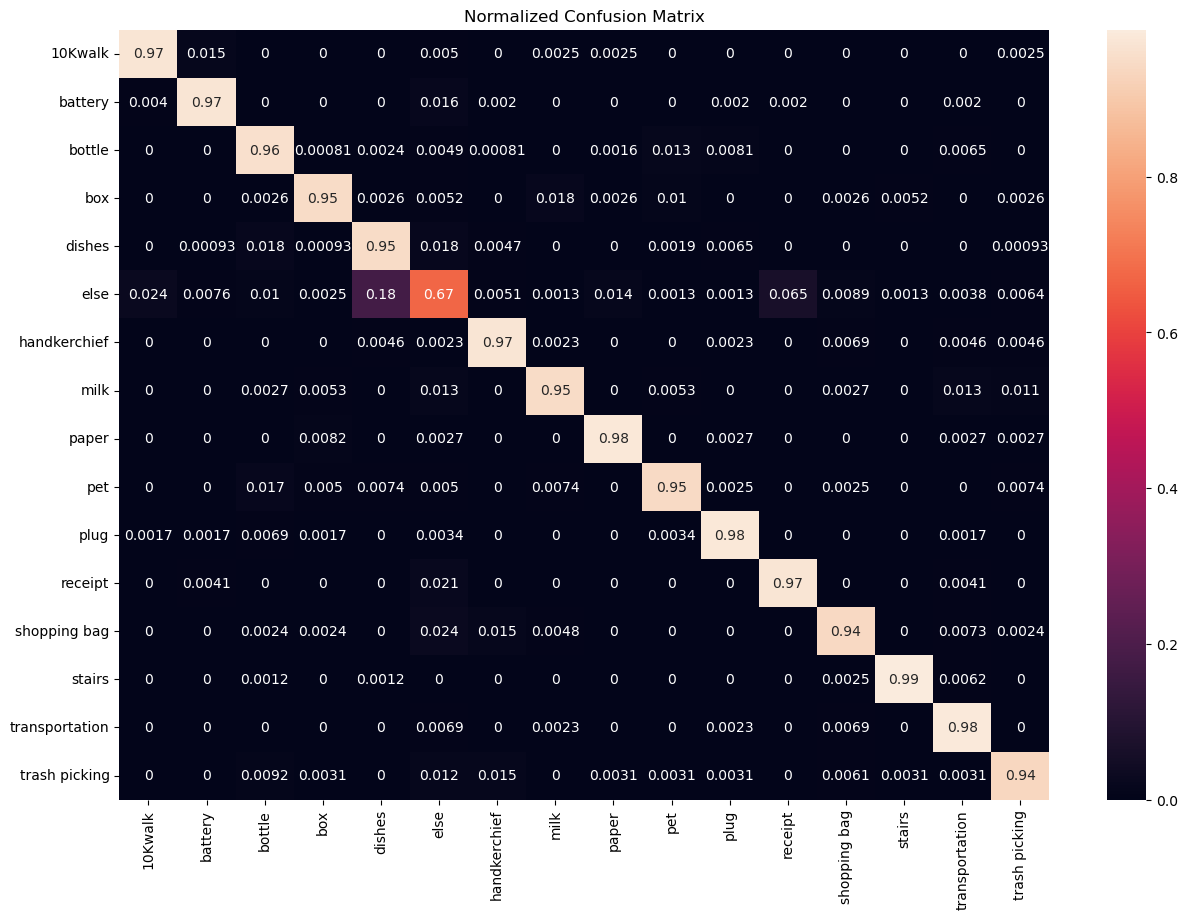

In [21]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
#test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')

In [23]:
test.to_csv('test_result/incep_res_0403.csv', index=False)